In [1]:
import os
import sys
import time
import warnings
import pandas as pd
import numpy as np
import QuantLib as ql
from pathlib import Path
import modin.pandas as md
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime
from matplotlib import cm
from model_settings import ms
pd.set_option("display.float_format", "{:.6f}".format)
warnings.filterwarnings("ignore", ".*defaulting to pandas implementation.*")
notebook_dir = str(Path().resolve())
sys.path.append(str(Path().resolve().parent))
sys.path.append(str(Path().resolve().parent.parent))
from historical_av_key_collector import keys_df, symbol, h5_name
h5_path = os.path.join(notebook_dir,f'alphaVantage {symbol}.h5')
store = pd.HDFStore(h5_path)
store.close()


pricing settings:
Actual/365 (Fixed) day counter
New York stock exchange calendar
compounding: continuous
frequency: annual

                              date                   spot_price  \
0     /date_2024_10_11/date_string  /date_2024_10_11/spot_price   
1     /date_2024_10_10/date_string  /date_2024_10_10/spot_price   
2     /date_2024_10_09/date_string  /date_2024_10_09/spot_price   
3     /date_2024_10_08/date_string  /date_2024_10_08/spot_price   
4     /date_2024_10_07/date_string  /date_2024_10_07/spot_price   
...                            ...                          ...   
4216  /date_2008_01_08/date_string  /date_2008_01_10/spot_price   
4217  /date_2008_01_07/date_string  /date_2008_01_09/spot_price   
4218  /date_2008_01_04/date_string  /date_2008_01_08/spot_price   
4219  /date_2008_01_03/date_string  /date_2008_01_07/spot_price   
4220  /date_2008_01_02/date_string  /date_2008_01_04/spot_price   

                   raw_data_key               surface_key  \
0     /d

# available time-series

# volatility surface query

# calibrations

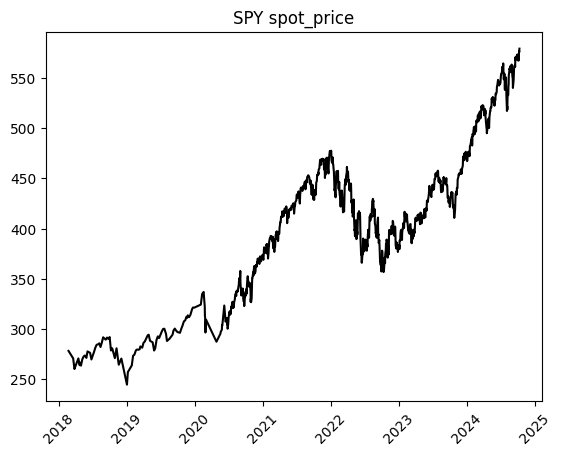

<Figure size 640x480 with 0 Axes>

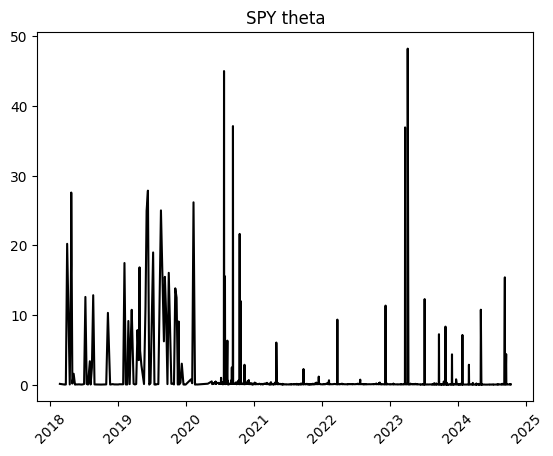

<Figure size 640x480 with 0 Axes>

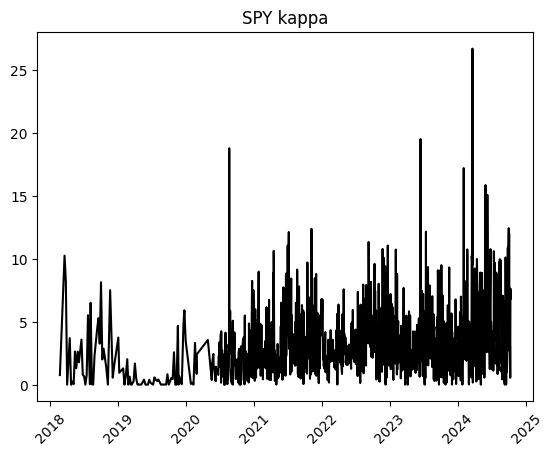

<Figure size 640x480 with 0 Axes>

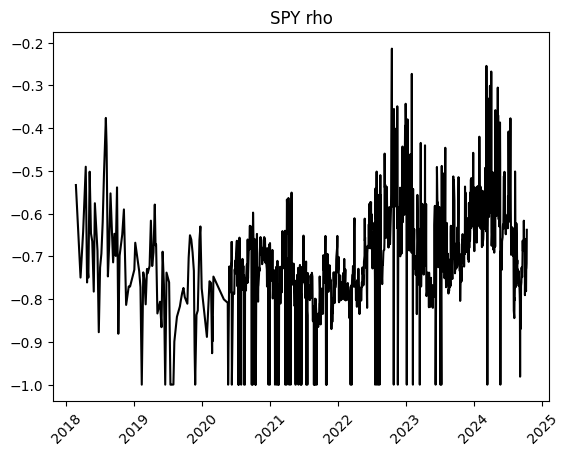

<Figure size 640x480 with 0 Axes>

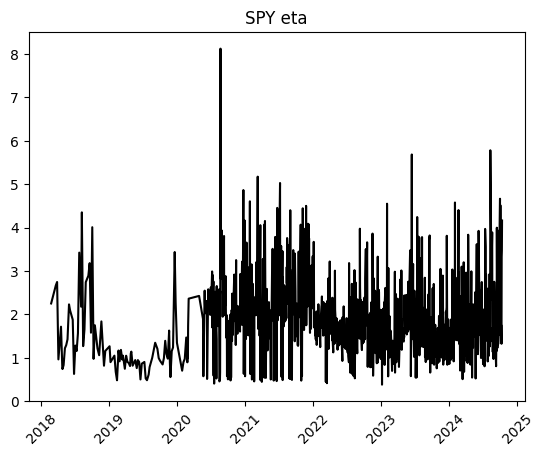

<Figure size 640x480 with 0 Axes>

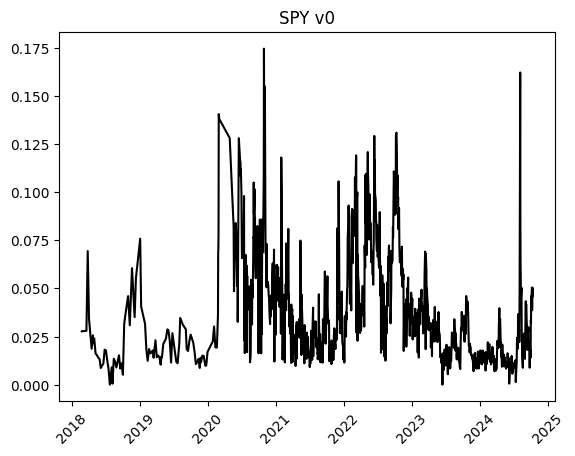


                    calculation_date   strike_price   market_price  \
count                        2781065 2781065.000000 2761702.000000   
mean   2022-07-04 02:28:08.957287936     398.357141      34.519704   
min              2018-02-22 00:00:00       5.000000       0.000000   
25%              2021-06-10 00:00:00     324.000000       0.480000   
50%              2022-05-25 00:00:00     400.000000       7.980000   
75%              2023-08-08 00:00:00     470.000000      42.610000   
max              2024-10-11 00:00:00    4898.000000     461.370000   
std                              NaN     117.103854      57.486082   

          volatility  days_to_maturity     spot_price  risk_free_rate  \
count 2781065.000000    2781065.000000 2781065.000000  2781065.000000   
mean        0.269669        109.841293     428.888574        0.040000   
min         0.006110         30.000000     244.210000        0.040000   
25%         0.167240         50.000000     389.990000        0.040000   
50%

<Figure size 640x480 with 0 Axes>

In [3]:
calibration_keys = keys_df.copy().dropna(subset=['calibration_key','parameter_key'])
calibrations = []
parameters = {}
while True:
    try:
        store.open()
        for i,row in calibration_keys.iterrows():
            calibrations.append(store[row['calibration_key']])
            parameters[row['date']] = store[row['parameter_key']]
        break
    except Exception as e:
        print(e)
        print('retrying in...')
        for i in range(2):
            print(2-i)
            time.sleep(1)
    finally:
        store.close()

calibrations = pd.concat(calibrations,ignore_index=True).dropna(subset='strike_price')
calibrations['calculation_date'] = pd.to_datetime(calibrations['calculation_date'],format='%Y-%m-%d')
calibrations = calibrations.set_index('calculation_date').sort_index()
parameters = calibrations[['spot_price','theta','kappa','rho','eta','v0']].drop_duplicates()

for col in parameters.columns:
    plt.figure()
    plt.plot(calibrations[col], color='black')
    plt.xticks(rotation=45)
    plt.title(symbol + ' ' + col)
    plt.show()
    plt.clf()
print(f"\n{calibrations.reset_index().describe()}")

## calibration testing

In [4]:
problem_parameter = 'v0'
problem_theshold = 0.2
problems = pd.Series(calibrations[problem_parameter][calibrations[problem_parameter]>problem_theshold].drop_duplicates().index).dt.strftime('/date_%Y_%m_%d/heston_calibration/calibration_results')
dfs = {}
with pd.HDFStore(h5_name) as store:
    for key in problems:
        dfs[key] = store[key]
store.close()
print('problem calibration(s):')
for i,dfk in enumerate(dfs.keys()):
    print(f"{i}     {dfk}")
problem_keys = keys_df[keys_df['calibration_key'].isin(problems)]

problem calibration(s):


In [5]:
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    problem_idx = 1
    with pd.HDFStore(h5_name) as store:
        surface = store[problem_keys['surface_key'].iloc[problem_idx]].drop_duplicates()
        heston_parameters = store[problem_keys['parameter_key'].iloc[problem_idx]]
        calibration = store[problem_keys['calibration_key'].iloc[problem_idx]]
        raw_data = store[problem_keys['raw_data_key'].iloc[problem_idx]]
        problem_date = str(store[problem_keys['date'].iloc[problem_idx]].iloc[0])
        problem_spot = float(store[problem_keys['spot_price'].iloc[problem_idx]].iloc[0])
    store.close()
    print(problem_date)
    previous_avgabs = np.mean(np.abs(calibration['error']))
    print("original calibration:")
    plot_vol_surface(surface)
    print(heston_parameters)
    calculation_datetime = datetime.strptime(problem_date,'%Y-%m-%d')
    calculation_date = ql.Date(
        calculation_datetime.day,
        calculation_datetime.month,
        calculation_datetime.year
    )
    printdate = str(calculation_datetime.strftime('%A, ')+str(calculation_date))
    print(f"average absolute error: {round(previous_avgabs,2)}")
    print(printdate)

    
    spot = problem_spot
    df = raw_data.copy()
    df['volume'] = pd.to_numeric(df['volume'])
    df['implied_volatility'] = pd.to_numeric(df['implied_volatility'])
    df['strike'] = pd.to_numeric(df['strike'])
    df['volume'] = pd.to_numeric(df['volume'])
    df['expiration'] = pd.to_datetime(df['expiration'],format='%Y-%m-%d')
    df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d')
    df['days_to_maturity'] = df['expiration'] - df['date']
    df['days_to_maturity'] = df['days_to_maturity'] // np.timedelta64(1, 'D')
    df['days_to_maturity'] = df['days_to_maturity'].astype('int64')
    df = df[(df['days_to_maturity']>=30)&(df['days_to_maturity']<=400)]
    df = df[['strike','implied_volatility','days_to_maturity','volume','type']]
    df = df[df['volume']>0].copy()
    df['spot_price'] = spot
    df['moneyness'] = ms.vmoneyness(df['spot_price'],df['strike'],df['type'])
    df = df[(df['moneyness']<0)&(df['moneyness']>-0.5)]
    indexed = df.copy().set_index(['strike','days_to_maturity'])
    
    T = np.sort(df['days_to_maturity'].unique()).tolist()
    K = np.sort(df['strike'].unique()).tolist()
    raw_surface = pd.DataFrame(
        np.tile(np.nan,(len(K),len(T))),
        index = K,
        columns = T
    )
    
    for k in K:
        for t in T:
            try:
                raw_surface.loc[k,t] = indexed.loc[(k,t),'implied_volatility']
            except Exception:
                pass
    raw_data = df.copy()
    raw_surface = raw_surface.dropna(how='any',axis=0).dropna(how='any',axis=1)
    print(f"{symbol} spot price: {spot}")
    vol_matrix = raw_surface.copy()

no issues with v0


## manual recalibration

In [6]:
if problem_keys.shape[0] == 0:
    print(f"no issues with {problem_parameter}")
    pass
else:
    raw_data = raw_data.rename(
        columns={
            'strike':'strike_price',
            'type':'w',
            'implied_volatility':'volatility'
        }
    )
    vol_matrix = vol_matrix.sort_index().drop_duplicates()
    s = spot
    T = vol_matrix.columns.tolist()
    K = vol_matrix.index.tolist()
    r = 0.04
    g = 0.0
    
    ql.Settings.instance().evaluationDate = calculation_date
    flat_ts, dividend_ts = ms.ql_ts_rg(r, g, calculation_date)
    S_handle = ql.QuoteHandle(ql.SimpleQuote(s))
    
    heston_helpers = []
    v0 = 0.01; kappa = 0.2; theta = 0.02; rho = -0.75; eta = 0.5;
    process = ql.HestonProcess(
        flat_ts,
        dividend_ts,
        S_handle,
        v0,                # Initial volatility
        kappa,             # Mean reversion speed
        theta,             # Long-run variance (volatility squared)
        eta,               # Volatility of the volatility
        rho                # Correlation between asset and volatility
    )
    model = ql.HestonModel(process)
    engine = ql.AnalyticHestonEngine(model)
    
    for t in T:
        for k in K:
            p = ql.Period(int(t),ql.Days)
            volatility = vol_matrix.loc[k,t]
            helper = ql.HestonModelHelper(
                p, ms.calendar, float(s), k, 
                ql.QuoteHandle(ql.SimpleQuote(volatility)), 
                flat_ts, 
                dividend_ts
                )
            helper.setPricingEngine(engine)
            heston_helpers.append(helper)
    
    lm = ql.LevenbergMarquardt(1e-8, 1e-8, 1e-8)
    
    model.calibrate(heston_helpers, lm,
                      ql.EndCriteria(1000, 50, 1.0e-8,1.0e-8, 1.0e-8))
    
    theta, kappa, eta, rho, v0 = model.params()
    heston_parameters = pd.Series(
        [theta, kappa, eta, rho, v0],
        index = ['theta', 'kappa', 'eta', 'rho', 'v0'],
        dtype = float
    )
    calibration_test_data = raw_data.copy()
    calibration_test_data['spot_price'] = s
    calibration_test_data['risk_free_rate'] = r
    calibration_test_data['dividend_rate'] = g
    calibration_test_data = calibration_test_data[calibration_test_data['days_to_maturity'].isin(df['days_to_maturity'])]
    calibration_test_data[heston_parameters.index.tolist()] = np.tile(heston_parameters,(calibration_test_data.shape[0],1))
    calibration_test_data.loc[:,'moneyness'] = ms.vmoneyness(
        calibration_test_data['spot_price'].values,
        calibration_test_data['strike_price'].values,
        calibration_test_data['w'].values
    )
    calibration_test_data['calculation_date'] = problem_date
    calibration_test_data['black_scholes'] = ms.vector_black_scholes(calibration_test_data)
    calibration_test_data['heston_price'] = ms.vector_heston_price(calibration_test_data)
    calibration_test_data.loc[:,'error'] = calibration_test_data['heston_price'].values - calibration_test_data['black_scholes'].values
    avg = np.mean(np.abs(calibration_test_data['error']))

    print("recalibrated:")
    plot_vol_surface(vol_matrix)
    print(f"\n{printdate}\n{heston_parameters}\n\naverage absolute error: {round(avg,3)}")
    print(f"previous error: {round(previous_avgabs,3)}\nchange: {round(avg-previous_avgabs,4)}")
    print(f"\n\ncalibration testing dataset:\n{calibration_test_data.describe()}")
    print(f"\n{calibration_test_data.dtypes}")

no issues with v0


### ENTRY REPLACEMENT

In [7]:
def replace_calibration_data():
    results_replacement_key = problem_keys.iloc[problem_idx]['calibration_key']
    parameter_replacement_key = problem_keys.iloc[problem_idx]['parameter_key']
    surface_replacement_key = problem_keys.iloc[problem_idx]['surface_key']
    with pd.HDFStore(h5_name) as store:
        store.put(surface_replacement_key,vol_matrix,format='table',append=False)
        store.put(parameter_replacement_key,heston_parameters,format='table',append=False)
        store.put(results_replacement_key,calibration_test_data,format='table',append=False)
        print(f'{results_replacement_key} | {parameter_replacement_key} | {surface_replacement_key}:     replaced')
    store.close()
try:
    print(printdate)
except Exception:
    pass

# checking dates

In [20]:
keys_df

,date,spot_price,raw_data_key,surface_key,calibration_key,parameter_key
0,/date_2024_10_11/date_string,/date_2024_10_11/spot_price,/date_2024_10_11/raw_data,/date_2024_10_11/surface,/date_2024_10_11/heston_calibration/calibratio...,/date_2024_10_11/heston_calibration/heston_par...
1,/date_2024_10_10/date_string,/date_2024_10_10/spot_price,/date_2024_10_10/raw_data,/date_2024_10_10/surface,/date_2024_10_10/heston_calibration/calibratio...,/date_2024_10_10/heston_calibration/heston_par...
2,/date_2024_10_09/date_string,/date_2024_10_09/spot_price,/date_2024_10_09/raw_data,/date_2024_10_09/surface,/date_2024_10_09/heston_calibration/calibratio...,/date_2024_10_09/heston_calibration/heston_par...
3,/date_2024_10_08/date_string,/date_2024_10_08/spot_price,/date_2024_10_08/raw_data,/date_2024_10_08/surface,/date_2024_10_08/heston_calibration/calibratio...,/date_2024_10_08/heston_calibration/heston_par...
4,/date_2024_10_07/date_string,/date_2024_10_07/spot_price,/date_2024_10_07/raw_data,/date_2024_10_07/surface,/date_2024_10_07/heston_calibration/calibratio...,/date_2024_10_07/heston_calibration/heston_par...
...,...,...,...,...,...,...
4216,/date_2008_01_08/date_string,/date_2008_01_10/spot_price,/date_2008_01_08/raw_data,NaN,NaN,NaN
4217,/date_2008_01_07/date_string,/date_2008_01_09/spot_price,/date_2008_01_07/raw_data,NaN,NaN,NaN
4218,/date_2008_01_04/date_string,/date_2008_01_08/spot_price,/date_2008_01_04/raw_data,NaN,NaN,NaN
4219,/date_2008_01_03/date_string,/date_2008_01_07/spot_price,/date_2008_01_03/raw_data,NaN,NaN,NaN


In [21]:
keys_df_dates = keys_df.copy().dropna(subset=['calibration_key'])
for i, row in keys_df_dates.iterrows():
    with pd.HDFStore(h5_name) as store:
        keys_df_dates.at[i,'extracted_date'] = store[row['date']].iloc[0]
        keys_df_dates.at[i,'calibration_date'] = store[row['calibration_key']]['calculation_date'].drop_duplicates().iloc[0]
        keys_df_dates.at[i,'data_date'] = store[row['raw_data_key']]['date'].drop_duplicates().iloc[0]
        keys_df_dates.at[i,'spot_price_date'] = row['spot_price']
store.close()
keys_df_dates = keys_df_dates.copy()[['date','extracted_date','calibration_date','data_date','spot_price_date','spot_price']]

In [24]:
keys_df_dates

,date,extracted_date,calibration_date,data_date,spot_price_date,spot_price
0,/date_2024_10_11/date_string,2024-10-11,2024-10-11,2024-10-11,/date_2024_10_11/spot_price,/date_2024_10_11/spot_price
1,/date_2024_10_10/date_string,2024-10-10,2024-10-10,2024-10-10,/date_2024_10_10/spot_price,/date_2024_10_10/spot_price
2,/date_2024_10_09/date_string,2024-10-09,2024-10-09,2024-10-09,/date_2024_10_09/spot_price,/date_2024_10_09/spot_price
3,/date_2024_10_08/date_string,2024-10-08,2024-10-08,2024-10-08,/date_2024_10_08/spot_price,/date_2024_10_08/spot_price
4,/date_2024_10_07/date_string,2024-10-07,2024-10-07,2024-10-07,/date_2024_10_07/spot_price,/date_2024_10_07/spot_price
...,...,...,...,...,...,...
1183,/date_2020_01_29/date_string,2020-01-29,2018-04-16,2020-01-29,/date_2020_01_29/spot_price,/date_2020_01_29/spot_price
1184,/date_2020_01_28/date_string,2020-01-28,2018-04-02,2020-01-28,/date_2020_01_28/spot_price,/date_2020_01_28/spot_price
1185,/date_2020_01_27/date_string,2020-01-27,2018-03-26,2020-01-27,/date_2020_01_27/spot_price,/date_2020_01_27/spot_price
1186,/date_2020_01_24/date_string,2020-01-24,2018-03-19,2020-01-24,/date_2020_01_24/spot_price,/date_2020_01_24/spot_price


In [25]:
dates_analysis = keys_df_dates.copy()
def extract_date_from_string(s):
    first_hyphen_pos = s.find('_',0)
    second_slash_pos = s.rfind('/',1)
    return s[first_hyphen_pos+1:second_slash_pos].replace('_','-')

dates_analysis['spot_price_date'] = dates_analysis['spot_price_date'].apply(extract_date_from_string)
dates_analysis['date'] = dates_analysis['date'].apply(extract_date_from_string)
dates_analysis

,date,extracted_date,calibration_date,data_date,spot_price_date,spot_price
0,2024-10-11,2024-10-11,2024-10-11,2024-10-11,2024-10-11,/date_2024_10_11/spot_price
1,2024-10-10,2024-10-10,2024-10-10,2024-10-10,2024-10-10,/date_2024_10_10/spot_price
2,2024-10-09,2024-10-09,2024-10-09,2024-10-09,2024-10-09,/date_2024_10_09/spot_price
3,2024-10-08,2024-10-08,2024-10-08,2024-10-08,2024-10-08,/date_2024_10_08/spot_price
4,2024-10-07,2024-10-07,2024-10-07,2024-10-07,2024-10-07,/date_2024_10_07/spot_price
...,...,...,...,...,...,...
1183,2020-01-29,2020-01-29,2018-04-16,2020-01-29,2020-01-29,/date_2020_01_29/spot_price
1184,2020-01-28,2020-01-28,2018-04-02,2020-01-28,2020-01-28,/date_2020_01_28/spot_price
1185,2020-01-27,2020-01-27,2018-03-26,2020-01-27,2020-01-27,/date_2020_01_27/spot_price
1186,2020-01-24,2020-01-24,2018-03-19,2020-01-24,2020-01-24,/date_2020_01_24/spot_price


In [26]:
keys_df.dtypes

date               object
spot_price         object
raw_data_key       object
surface_key        object
calibration_key    object
parameter_key      object
dtype: object